In [2]:
from torchvision import transforms
from torch.utils.data import DataLoader
# Imports PIL module
from PIL import Image

# %matplotlib inline
import matplotlib.pyplot as plt
import numpy as np


In [11]:
# Image transformations
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Validation does not use augmentation
    'valid':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

tensor([[[-0.3541, -0.3541, -0.3541,  ..., -0.4226, -0.4568, -0.4226],
         [-0.3541, -0.3541, -0.3541,  ..., -0.4054, -0.4226, -0.4054],
         [-0.3541, -0.3541, -0.3541,  ..., -0.4226, -0.4226, -0.4054],
         ...,
         [-0.0801,  0.1597,  0.1083,  ...,  0.0056,  0.1254,  0.1939],
         [-0.1828,  0.0741,  0.0398,  ...,  0.1254,  0.2453,  0.0056],
         [ 0.1426,  0.1254, -0.2342,  ...,  0.0398,  0.1768, -0.0801]],

        [[ 0.9405,  0.9405,  0.9405,  ...,  0.8704,  0.8354,  0.8704],
         [ 0.9405,  0.9405,  0.9405,  ...,  0.8880,  0.8704,  0.8880],
         [ 0.9405,  0.9405,  0.9405,  ...,  0.8704,  0.8704,  0.8880],
         ...,
         [ 0.1001,  0.3277,  0.2752,  ...,  0.4328,  0.5903,  0.6779],
         [-0.0224,  0.2052,  0.1877,  ...,  0.5203,  0.6604,  0.4153],
         [ 0.3102,  0.2577, -0.0924,  ...,  0.4328,  0.5728,  0.2927]],

        [[ 2.1171,  2.1171,  2.1171,  ...,  2.0125,  1.9777,  2.0125],
         [ 2.1171,  2.1171,  2.1171,  ...,  2

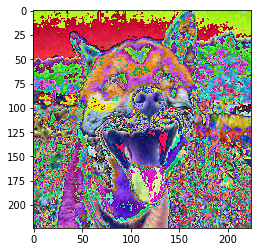

In [22]:
%matplotlib inline
# open method used to open different extension image file
im = Image.open(r"root/dog/0-0.jpg")
x = image_transforms["train"](im)

# x = preprocess(img)
print(x)
print(x.shape)
print(type(x))

# This method will show image in any image viewer
# im.show()

reverse_preprocess = transforms.Compose([
    transforms.ToPILImage(),
    np.array,
])

plt.imshow(reverse_preprocess(x))

In [14]:
from torchvision import models
model = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /Users/zhuminhao/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [17]:
import torch.nn as nn

# Freeze model weights
for param in model.parameters():
    param.requires_grad = False
    

# Add on classifier
model.classifier[6] = nn.Sequential(
                      nn.Linear(60, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, 4),                   
                      nn.LogSoftmax(dim=1))

In [18]:
# Only training classifier[6]
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Sequential(
    (0): Linear(in_features=60, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=256, out_features=4, bias=True)
    (4): LogSoftmax(dim=1)
  )
)

In [20]:
model2 = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/zhuminhao/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [27]:
from tensorflow.keras.applications.resnet50 import ResNet50
ResNet50_model_ = ResNet50(weights='imagenet')

102981632/102967424 [==============================] - 11s 0us/step


In [28]:
from keras.preprocessing import image             
from tqdm import tqdm
def path_to_tensor(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)
def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [39]:
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
def ResNet50_predict_labels(img_path):
    img = preprocess_input(paths_to_tensor(img_path))
    return np.argmax(ResNet50_model_.predict(img))

def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)

    return ((prediction <= 268) & (prediction >= 151))

In [42]:
import os
path = os.getcwd() + "/dog"
paths = os.listdir(path)
for index, item in enumerate(paths):
    paths[index] = os.getcwd() + "/dog/" + item

dog_detector(paths)


AttributeError: 'int' object has no attribute 'toArray'